## Установка и импорт библиотек

In [2]:
!pip install \
  ultralytics \
  pandas \
  numpy \
  matplotlib \
  seaborn \
  opencv-python \
  Pillow \
  pyyaml \
  tqdm \
  torch torchvision \
  scikit-learn

  

In [3]:
from ultralytics import YOLO

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
from PIL import Image

import os
import shutil
import random 
from pathlib import Path
from collections import defaultdict 
from collections import Counter 

import yaml
from tqdm import tqdm

import torch
from sklearn.model_selection import train_test_split

## Подготовка структуры датасета под YOLO 

 Создаём все нужные фолдеры

In [5]:
#Исходные директории 
images_dir = Path("../datasets/raw-dataset/films-1000")
labels_dir = Path("../datasets/raw-dataset/labels/train")

#Структура под YOLO 
dataset_root = Path("../datasets/dataset-structure-for-yolo") 
train_img_dir = dataset_root / "images" / "train"
val_img_dir = dataset_root / "images" / "val"
train_lbl_dir = dataset_root / "labels" / "train"
val_lbl_dir = dataset_root / "labels" / "val"

#Создаём нужные папки
for directory in [train_img_dir, val_img_dir, train_lbl_dir, val_lbl_dir]:
    directory.mkdir(parents=True, exist_ok=True)

Посмотрим на соответствие число изображений и масок 

In [6]:
label_files = {f.stem: f for f in labels_dir.rglob("*.txt")}
image_files = {f.stem: f for f in images_dir.rglob("*.png")}

print(f"Найдено изображений: {len(image_files)}")
print(f"Найдено масок: {len(label_files)}")

Найдено изображений: 999
Найдено масок: 957


In [7]:
# Сопоставляем
common_stems = label_files.keys() & image_files.keys()
only_labels = label_files.keys() - image_files.keys()
only_images = image_files.keys() - label_files.keys()

# Статистика
matched = len(common_stems)
unmatched_txt = len(only_labels)
unmatched_png = len(only_images)

matched, unmatched_txt, unmatched_png

(957, 0, 42)

In [8]:
# Очистка предыдущего содержимого если что-то пошло не так 
for d in [train_img_dir, val_img_dir, train_lbl_dir, val_lbl_dir]:
    for f in d.glob("*"):
        f.unlink()

Разобьём датасет на train и val

In [9]:
# Преобразуем все доступные изображения в список
all_image_ids = list(common_stems)

# Разделим на train и val (80/20)
train_ids, val_ids = train_test_split(
    all_image_ids, test_size=0.2, random_state=42
)

# Функция для копирования .png и .txt
def copy_pair(image_id, img_dst, lbl_dst):
    image_path = image_files.get(image_id)
    label_path = label_files.get(image_id)
    if image_path and label_path:
        shutil.copy2(image_path, img_dst / f"{image_id}.png")
        shutil.copy2(label_path, lbl_dst / f"{image_id}.txt")



# Копируем train
for image_id in train_ids:
    copy_pair(image_id, train_img_dir, train_lbl_dir)

# Копируем val 
for image_id in val_ids:
    copy_pair(image_id, val_img_dir, val_lbl_dir)

# Проверка 
print(f"Train: {len(train_ids)} изображений")
print(f"Val: {len(val_ids)} изображений")
print(f"Всего: {len(common_stems)} (проверка)")

Train: 765 изображений
Val: 192 изображений
Всего: 957 (проверка)


Построение гистаграммы распределения объектов по классам в train и val  

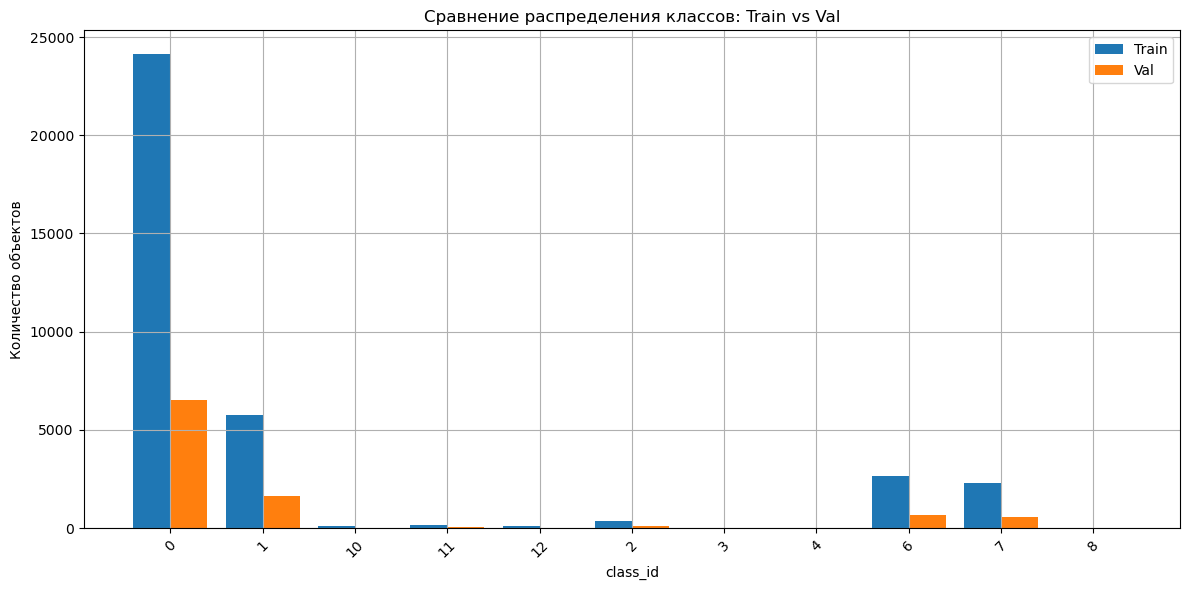

In [10]:
# Подсчёт количества объектов каждого класса в папке с .txt
def count_classes_in_dir(label_dir: Path) -> pd.DataFrame:
    counter = Counter()
    for label_file in label_dir.glob("*.txt"):
        with label_file.open("r", encoding='utf-8') as f:
            for line in f:
                parts = line.strip().split()
                if parts:
                    cls = parts[0]
                    counter[cls] += 1
    return pd.DataFrame(counter.items(), columns=["class_id", "count"]).sort_values("class_id")

#  Пути к разметкам
train_lbl_dir = Path("../datasets/dataset-structure-for-yolo/labels/train")
val_lbl_dir = Path("../datasets/dataset-structure-for-yolo/labels/val")

#  Подсчёт
train_df = count_classes_in_dir(train_lbl_dir)
val_df = count_classes_in_dir(val_lbl_dir)

# Объединяем по всем классам
all_classes = sorted(set(train_df["class_id"]) | set(val_df["class_id"]))
train_df = train_df.set_index("class_id").reindex(all_classes, fill_value=0).reset_index()
val_df = val_df.set_index("class_id").reindex(all_classes, fill_value=0).reset_index()

# Рисуем картиночку
x = range(len(all_classes))
plt.figure(figsize=(12, 6))
plt.bar(x, train_df["count"], width=0.4, label="Train", align="center")
plt.bar([i + 0.4 for i in x], val_df["count"], width=0.4, label="Val", align="center")
plt.xticks([i + 0.2 for i in x], all_classes, rotation=45)
plt.xlabel("class_id")
plt.ylabel("Количество объектов")
plt.title("Сравнение распределения классов: Train vs Val")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


## Построение base-line модели YOLOv11x-seg

Объявление конфигурации модели и запись в файл

In [10]:
train_path = Path("../datasets/dataset-structure-for-yolo/images/train").resolve()
val_path = Path("../datasets/dataset-structure-for-yolo/images/val").resolve()

data_config = {
    "train": str(train_path),
    "val": str(val_path),
    "nc": 13,
    "names": {
        "0": "пора",
        "1": "включение",
        "2": "подрез",
        "3": "прожог",
        "4": "трещина",
        "5": "наплыв",
        "6": "эталон1",
        "7": "эталон2",
        "8": "эталон3",
        "9": "пора-скрытая",
        "10": "утяжина",
        "11": "несплавление",
        "12": "непровар корня"
    }
}

config_path = Path("../configs/data.yaml")

with open(config_path, "w", encoding="utf-8") as f:
    yaml.dump(data_config, f, allow_unicode=True)

print("YAML сохранён по пути:", config_path.resolve())

YAML сохранён по пути: C:\Users\maksk\Desktop\ml-yolo-train\configs\data.yaml


Настройка директорий под выводы модели

In [11]:
experiment_name = "yolov11xseg-baseline"
project_dir = "../logs"

weights_dir = Path("../models") / experiment_name
logs_dir = Path(project_dir) / experiment_name

for path in [weights_dir, logs_dir]:
    path.mkdir(parents=True, exist_ok=True)

print(f"Веса модели сохранятся в: {weights_dir}")
print(f"Логи и графики сохранятся в: {logs_dir}")

Веса модели сохранятся в: ..\models\yolov11xseg-baseline
Логи и графики сохранятся в: ..\logs\yolov11xseg-baseline


Обучение модели yolo11n-seg, самой маленькой из семейства yolo11. Только она влезла мне не gpu (8gb) при размере батча 1 картинка

In [12]:
model = YOLO("yolo11n-seg.pt")

In [13]:
model.train(
    data=str(config_path),
    imgsz=(320, 2880),   # yolo всё равно берёт квадрат по большей стороне, что бы не передавали       
    epochs=40,
    batch=1,
    device="cuda:0",
    patience=20,
    project=project_dir,
    name=experiment_name,
    save=True,
    save_period=10,
    val=True,
    exist_ok=True,
    plots=True,
    verbose=True
)

Ultralytics 8.3.131  Python-3.12.4 torch-2.4.1 CUDA:0 (NVIDIA GeForce RTX 3070 Ti Laptop GPU, 8192MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=..\configs\data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=(320, 2880), int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov11xseg-baseline, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=20, perspective=0.0, 

train: Scanning C:\Users\maksk\Desktop\ml-yolo-train\datasets\dataset-structure-for-yolo\labels\train... 765 images, 0 


train: New cache created: C:\Users\maksk\Desktop\ml-yolo-train\datasets\dataset-structure-for-yolo\labels\train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access  (ping: 0.10.0 ms, read: 348.248.3 MB/s, size: 16836.5 KB)


val: Scanning C:\Users\maksk\Desktop\ml-yolo-train\datasets\dataset-structure-for-yolo\labels\val... 192 images, 0 back


val: New cache created: C:\Users\maksk\Desktop\ml-yolo-train\datasets\dataset-structure-for-yolo\labels\val.cache
Plotting labels to ..\logs\yolov11xseg-baseline\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000588, momentum=0.9) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)
Image sizes 2880 train, 2880 val
Using 8 dataloader workers
Logging results to ..\logs\yolov11xseg-baseline
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/40      6.91G      2.252      2.692      26.82      1.017         12       2880: 100%|██████████| 765/765 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP


                   all        192       9561       0.88       0.14      0.118     0.0647      0.858      0.113     0.0867     0.0303

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/40       6.8G      1.434      1.108       19.6     0.7752          9       2880: 100%|██████████| 765/765 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        192       9561      0.842      0.183      0.192      0.135      0.815      0.158      0.147     0.0454



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/40      7.18G       1.25     0.9269      12.36     0.7823          8       2880: 100%|██████████| 765/765 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        192       9561      0.534      0.197      0.207      0.153      0.498      0.166      0.153     0.0497



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/40      6.32G      1.179     0.7882      11.78     0.7568         18       2880: 100%|██████████| 765/765 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        192       9561      0.314      0.203      0.209      0.146      0.274      0.168      0.151     0.0491



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/40      7.12G      1.108     0.7595      8.771      0.763         16       2880: 100%|██████████| 765/765 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        192       9561      0.203      0.208       0.21      0.165      0.172      0.176      0.158     0.0534



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/40      7.32G      1.091     0.7486      6.985     0.7633         13       2880: 100%|██████████| 765/765 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        192       9561      0.197      0.211      0.209      0.164      0.167      0.181      0.159     0.0534



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/40      6.14G      1.023     0.6533      6.759     0.7426          8       2880: 100%|██████████| 765/765 [04:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        192       9561      0.422      0.207      0.209       0.16      0.394       0.18      0.163     0.0587



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/40      7.23G      1.023     0.6104      5.468     0.7527         10       2880: 100%|██████████| 765/765 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        192       9561      0.534      0.215      0.212      0.168      0.512      0.193      0.175     0.0633



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/40      5.91G     0.9788     0.5918      5.038     0.7325         14       2880: 100%|██████████| 765/765 [04:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        192       9561      0.534      0.214      0.211      0.168       0.51      0.187      0.168     0.0595



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/40      6.55G     0.9901     0.6092      4.752     0.7288          9       2880: 100%|██████████| 765/765 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        192       9561      0.536       0.21      0.212      0.167      0.504      0.178      0.163     0.0555



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/40      6.39G     0.9433     0.5917      4.095     0.7275         18       2880: 100%|██████████| 765/765 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        192       9561      0.537      0.213      0.212      0.169      0.509      0.184      0.165     0.0585



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/40      6.25G     0.9406     0.5553      2.874      0.744         10       2880: 100%|██████████| 765/765 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        192       9561      0.541      0.215      0.214      0.176      0.511      0.185      0.168     0.0557



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/40      6.62G     0.8972     0.5275      3.479     0.7153         17       2880: 100%|██████████| 765/765 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        192       9561       0.54      0.212      0.213      0.169      0.515      0.187      0.172     0.0572



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/40      6.55G     0.9289     0.5781      2.527     0.7404         17       2880: 100%|██████████| 765/765 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        192       9561       0.54      0.212      0.214      0.175      0.515      0.186      0.171     0.0642



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/40      5.95G     0.9626     0.5845      2.504      0.737          6       2880: 100%|██████████| 765/765 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        192       9561      0.542      0.211      0.214      0.171      0.518      0.187      0.175     0.0627



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/40      6.63G     0.8967     0.5401      2.335     0.7305         11       2880: 100%|██████████| 765/765 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        192       9561      0.541      0.213      0.214      0.179      0.518      0.191      0.177      0.064



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/40      6.28G      0.896     0.5312      2.391      0.721          0       2880: 100%|██████████| 765/765 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        192       9561       0.54      0.214      0.213      0.175      0.509      0.182      0.162     0.0584



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/40      6.97G     0.8811     0.5096      2.132     0.7253         14       2880: 100%|██████████| 765/765 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        192       9561      0.432      0.213      0.216       0.18       0.41      0.191      0.179     0.0647



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/40       6.2G     0.8574     0.4965      2.245     0.7117         11       2880: 100%|██████████| 765/765 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        192       9561      0.432      0.214      0.214       0.18      0.407      0.189      0.173     0.0615



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/40      6.94G     0.8704     0.4978      1.888      0.726          7       2880: 100%|██████████| 765/765 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        192       9561       0.32      0.215      0.215       0.18      0.296      0.191      0.175      0.063



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/40      6.13G      0.896     0.5201      1.822     0.7268         23       2880: 100%|██████████| 765/765 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        192       9561      0.432      0.213      0.215      0.181      0.407      0.186      0.172      0.061



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/40      8.45G     0.8831      0.527      1.608     0.7372          6       2880: 100%|██████████| 765/765 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        192       9561      0.209      0.215      0.215      0.179      0.186      0.192      0.178     0.0685



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/40      6.71G     0.8558      0.511      1.681     0.7162          0       2880: 100%|██████████| 765/765 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        192       9561      0.212      0.209      0.215       0.18      0.185      0.183      0.172     0.0651



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/40      6.48G     0.8458     0.4678      1.628     0.7125         15       2880: 100%|██████████| 765/765 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        192       9561      0.209      0.216      0.215      0.184      0.184      0.189      0.172     0.0628



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/40      5.88G     0.8328     0.4683       1.51     0.7211         12       2880: 100%|██████████| 765/765 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        192       9561      0.209      0.216      0.215      0.182      0.184      0.191      0.175     0.0649



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/40      5.98G     0.8247     0.4595      1.543     0.7171         13       2880: 100%|██████████| 765/765 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        192       9561      0.206      0.216      0.215      0.179      0.188      0.189      0.177     0.0656



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/40      6.39G     0.8032     0.4721      1.533     0.7049         16       2880: 100%|██████████| 765/765 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        192       9561      0.211      0.214      0.215      0.178      0.187       0.19      0.177     0.0661



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/40      7.03G      0.819     0.4792      1.488     0.7111         14       2880: 100%|██████████| 765/765 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        192       9561      0.207      0.213      0.214       0.18      0.186      0.192       0.18     0.0664



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/40      6.35G     0.8083     0.4534       1.39     0.7127          9       2880: 100%|██████████| 765/765 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        192       9561      0.211      0.214      0.216      0.184      0.185      0.191      0.176     0.0675



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/40      8.11G     0.8175     0.4631      1.337     0.7269         11       2880: 100%|██████████| 765/765 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        192       9561      0.211      0.216      0.215      0.183      0.189      0.194      0.178     0.0666


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      31/40      5.71G     0.8937     0.5696      1.712     0.7683          7       2880: 100%|██████████| 765/765 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        192       9561      0.314      0.214      0.212      0.177      0.291      0.191      0.173     0.0635



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      32/40      5.84G     0.8526     0.4767       1.52     0.7679          6       2880: 100%|██████████| 765/765 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        192       9561      0.202      0.209      0.211       0.18      0.178      0.186      0.172     0.0641



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      33/40      5.58G     0.8403     0.5018      1.494     0.7615          5       2880: 100%|██████████| 765/765 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        192       9561      0.207       0.21      0.212      0.178      0.184      0.187      0.175     0.0632



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      34/40       5.6G     0.8192     0.4603       1.45     0.7643          6       2880: 100%|██████████| 765/765 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        192       9561       0.21      0.211      0.215      0.182      0.188      0.189      0.177     0.0667



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      35/40      5.63G     0.8293     0.4671      1.462     0.7635          6       2880: 100%|██████████| 765/765 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        192       9561      0.209      0.214      0.214      0.182      0.187      0.192      0.179     0.0662



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      36/40      5.59G     0.8293     0.4716      1.455     0.7668          4       2880: 100%|██████████| 765/765 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        192       9561      0.209      0.212      0.215      0.183      0.186      0.188      0.176     0.0653



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      37/40      5.46G     0.8116     0.4859      1.431     0.7644          7       2880: 100%|██████████| 765/765 [05:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        192       9561      0.209      0.215      0.214      0.182      0.187      0.193      0.178     0.0662



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      38/40      5.59G     0.7929     0.4677      1.375     0.7669         10       2880: 100%|██████████| 765/765 [04:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        192       9561      0.208      0.215      0.215      0.185      0.186      0.193      0.179     0.0658



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      39/40      5.48G     0.7921     0.4441      1.364     0.7634          8       2880: 100%|██████████| 765/765 [04:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        192       9561      0.211      0.213      0.215      0.185       0.19      0.191      0.179     0.0662



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      40/40      5.92G     0.7833     0.4357      1.379     0.7589          6       2880: 100%|██████████| 765/765 [04:
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP

                   all        192       9561      0.211      0.213      0.215      0.184      0.188       0.19      0.178     0.0662



40 epochs completed in 3.947 hours.
Optimizer stripped from ..\logs\yolov11xseg-baseline\weights\last.pt, 6.0MB
Optimizer stripped from ..\logs\yolov11xseg-baseline\weights\best.pt, 6.0MB

Validating ..\logs\yolov11xseg-baseline\weights\best.pt...
Ultralytics 8.3.131  Python-3.12.4 torch-2.4.1 CUDA:0 (NVIDIA GeForce RTX 3070 Ti Laptop GPU, 8192MiB)
YOLO11n-seg summary (fused): 113 layers, 2,837,103 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP


                   all        192       9561      0.211      0.214      0.216      0.184      0.184      0.191      0.176     0.0675
                          191       6595          0          0          0          0          0          0          0          0
                     153       1498          0          0          0          0          0          0          0          0
                         42        108          0          0          0          0          0          0          0          0
               1        188        685      0.959      0.955      0.974      0.806      0.731      0.743      0.611      0.215
               2        189        568      0.944      0.972      0.972      0.849      0.929      0.979      0.971      0.392
               3          3          9          0          0          0          0          0          0          0          0
                        15         27          0          0          0          0          0          0   

ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  6,  7,  8, 10, 11, 12])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002A34BC415B0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,   

Строим датафрейм с метриками по последним 10 батчам и графики их изменения B - bbox, M - mask (код в следующей ячейке написан дикпиком, ничего не проверял)

Detected metric columns (without MAP): ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/precision(M)', 'metrics/recall(M)']


,epoch,metrics/precision(B),metrics/recall(B),metrics/precision(M),metrics/recall(M)
30,31,0.31355,0.21383,0.29079,0.19072
31,32,0.20161,0.20931,0.17835,0.18589
32,33,0.20690,0.21007,0.18391,0.18725
33,34,0.21002,0.21095,0.18773,0.18873
34,35,0.20854,0.21402,0.18698,0.19161
35,36,0.20923,0.21195,0.18592,0.18800
36,37,0.20911,0.21477,0.18679,0.19322
37,38,0.20838,0.21466,0.18628,0.19259
38,39,0.21089,0.21321,0.18985,0.19145
39,40,0.21074,0.21303,0.18807,0.19021


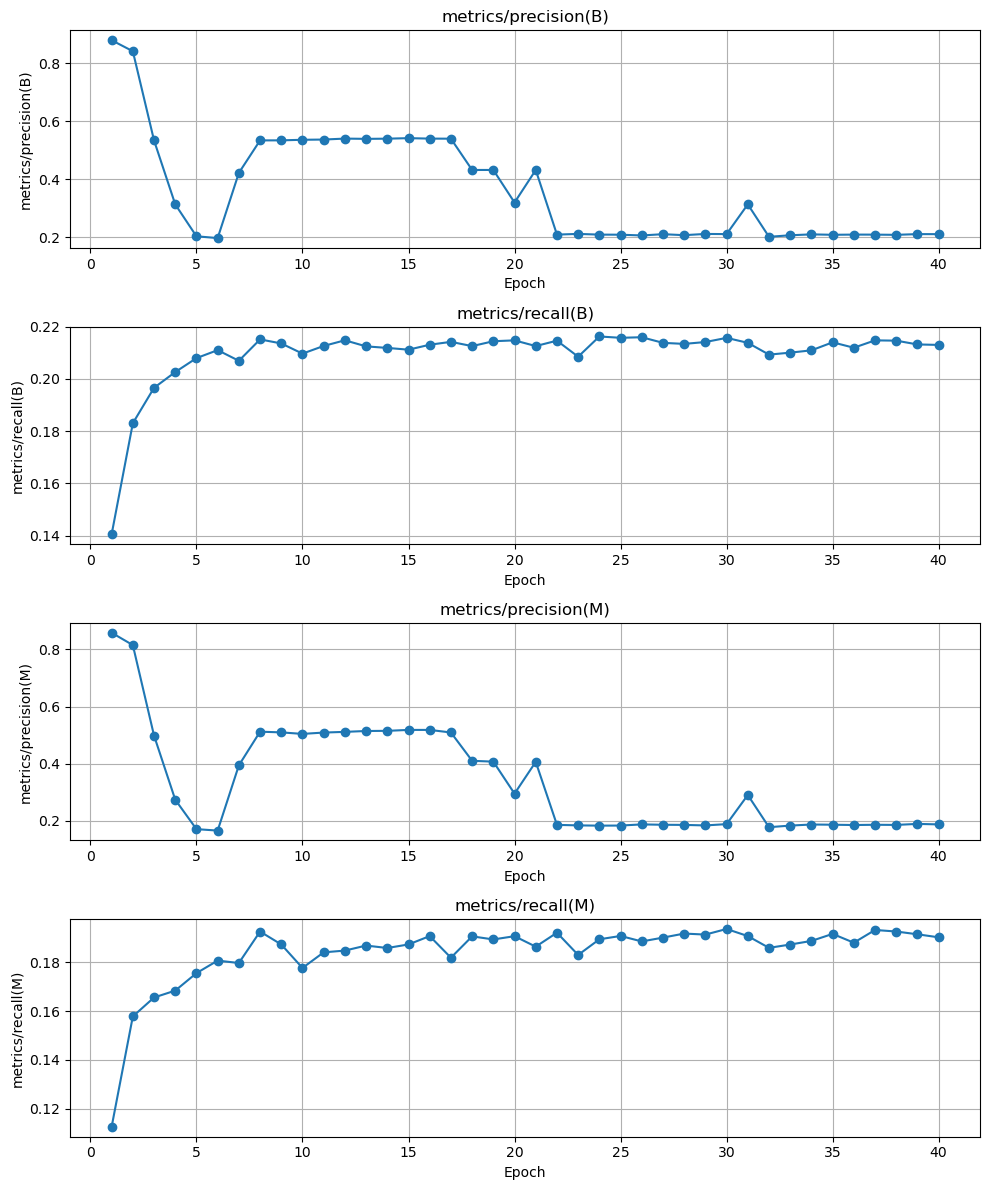

In [18]:
results_path = '../logs/yolov11xseg-baseline/results.csv'

# Читаем таблицу
df = pd.read_csv(results_path)

# Отбираем метрики без map, про них в кейсе не спрашивали
keywords = ['precision', 'recall']
metrics = [
    col for col in df.columns
    if any(kw in col.lower() for kw in keywords)
    and 'map' not in col.lower()
]


print("Detected metric columns (without MAP):", metrics)

display(df[['epoch'] + metrics].tail(10))


n = len(metrics)
fig, axes = plt.subplots(n, 1, figsize=(10, 3 * n), squeeze=False)

for ax, col in zip(axes.flatten(), metrics):
    ax.plot(df['epoch'], df[col], marker='o')
    ax.set_title(f"{col}")
    ax.set_xlabel('Epoch')
    ax.set_ylabel(col)
    ax.grid(True)

plt.tight_layout()
plt.show()